# Regresión lineal, Ridge y Lasso

## El objetivo es predecir el precio de una casa

### Dataset

El dataset está compuesto de las siguientes variables:
    
- Square_Footage
- Num_Bedrooms
- Num_Bathrooms
- Year_Built
- Lot_Size
- Garage_Size
- Neighborhood_Quality
- House_Price --> Variable a predecir

Todas las variables son numéricas
No hay valores nulos en ninguna columna
No hay outliers (datos atípicos)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [4]:
houses = pd.read_csv('C:/Users/spaul/OneDrive/Documentos/Otros/8vo semestre (4to)/IA2/houses.csv')
houses.dropna()
houses.head(3)

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,262382.852274
1,4272,3,3,2016,4.753014,1,6,985260.854490
2,3592,1,2,2016,3.634823,0,9,777977.390119


# Análisis Exploratorio de Datos

In [5]:
print("Forma del dataset:", houses.shape)
print("\nTipos de datos:\n", houses.dtypes)
print("\nNulos por columna:\n", houses.isnull().sum())
print("\nEstadísticas descriptivas:\n", houses.describe())

Forma del dataset: (1000, 8)

Tipos de datos:
 Square_Footage            int64
Num_Bedrooms              int64
Num_Bathrooms             int64
Year_Built                int64
Lot_Size                float64
Garage_Size               int64
Neighborhood_Quality      int64
House_Price             float64
dtype: object

Nulos por columna:
 Square_Footage          0
Num_Bedrooms            0
Num_Bathrooms           0
Year_Built              0
Lot_Size                0
Garage_Size             0
Neighborhood_Quality    0
House_Price             0
dtype: int64

Estadísticas descriptivas:
        Square_Footage  Num_Bedrooms  Num_Bathrooms   Year_Built     Lot_Size  \
count     1000.000000   1000.000000    1000.000000  1000.000000  1000.000000   
mean      2815.422000      2.990000       1.973000  1986.550000     2.778087   
std       1255.514921      1.427564       0.820332    20.632916     1.297903   
min        503.000000      1.000000       1.000000  1950.000000     0.506058   
25%       17

# Detección de outliers en la variable objetivo para eliminarlos de ser necesario

In [6]:
target_col = "House_Price"
Q1 = houses[target_col].quantile(0.25)
Q3 = houses[target_col].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers_mask = (houses[target_col] < lower) | (houses[target_col] > upper)
print("Outliers detectados:", outliers_mask.sum())

Outliers detectados: 0


# Análisis de Correlación
Para seleccionar las características más relevantes para nuestro modelo de regresión, se calcula la matriz de correlación entre las variables numéricas del dataset

In [32]:
corr = houses.corr(numeric_only=True)
abs_corr = corr[target_col].drop(target_col).abs().sort_values(ascending=False)
print("\nCorrelación absoluta con House_Price:\n", abs_corr)

top_features = abs_corr.head(6).index.tolist()
print(top_features)


Correlación absoluta con House_Price:
 Square_Footage          0.991261
Lot_Size                0.160412
Garage_Size             0.052133
Year_Built              0.051967
Num_Bedrooms            0.014633
Neighborhood_Quality    0.007770
Num_Bathrooms           0.001862
Name: House_Price, dtype: float64
['Square_Footage', 'Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms', 'Neighborhood_Quality', 'Num_Bathrooms']


| Variable               | Correlación absoluta con House_Price |
|------------------------|--------------------------------------|
| Square_Footage         | 0.991261                             |
| Lot_Size               | 0.160412                             |
| Garage_Size            | 0.052133                             |
| Year_Built             | 0.051967                             |
| Num_Bedrooms           | 0.014633                             |
| Num_Bathrooms          | 0.001862                             |

Como vemos, Square_Footage es la variable más correlacionada con la variable objetivo. Su correlación es casi lineal por lo que es la  variable dominante en el modelo.

## Graficamos la relación entre 'Square_Footage' y 'House_Price'

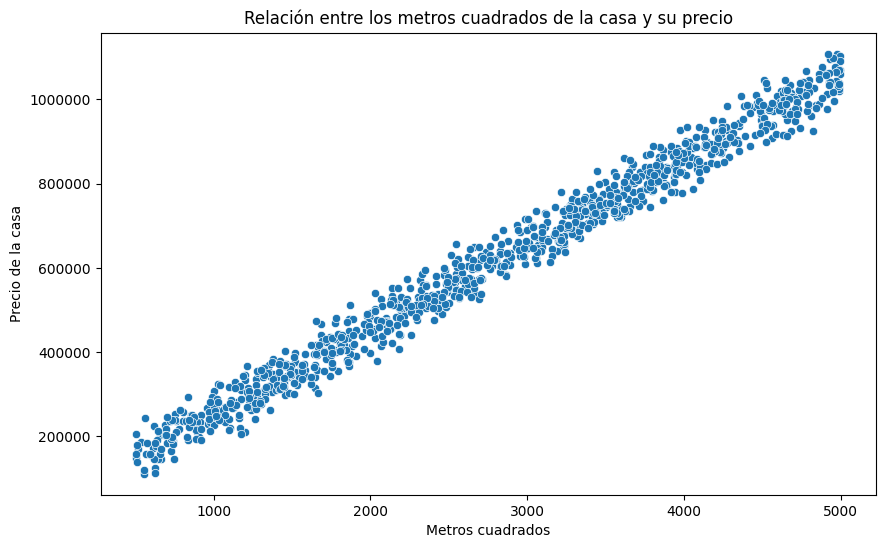

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Square_Footage', y='House_Price', data=houses)
plt.xlabel('Metros cuadrados')
plt.ylabel('Precio de la casa')
plt.title('Relación entre los metros cuadrados de la casa y su precio')
plt.ticklabel_format(style = 'plain')
plt.show()

## Graficamos la relación entre 'Square_Footage' y 'Lot_Size'

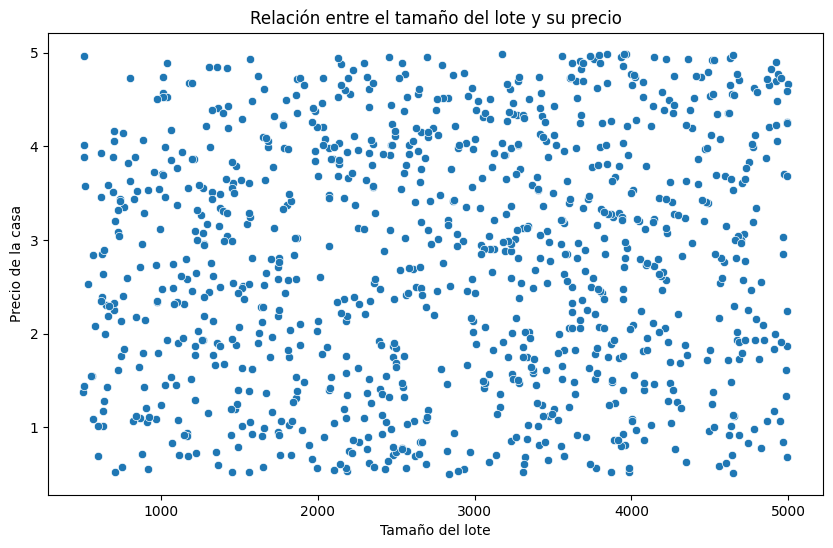

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Square_Footage', y='Lot_Size', data=houses)
plt.xlabel('Tamaño del lote')
plt.ylabel('Precio de la casa')
plt.title('Relación entre el tamaño del lote y su precio')
plt.ticklabel_format(style = 'plain')
plt.show()

# Graficamos la relación entre 'Square_Footage' y 'Garage_Size'¶

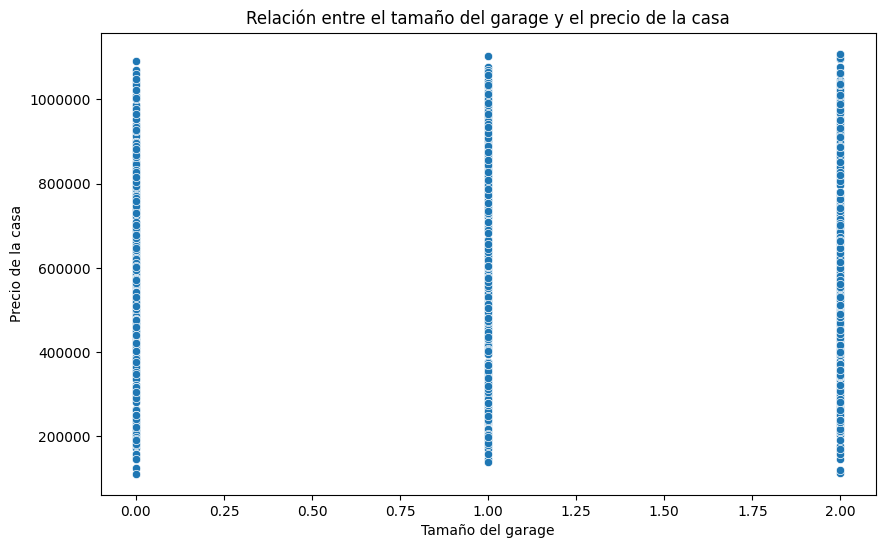

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Garage_Size', y='House_Price', data=houses)
plt.xlabel('Tamaño del garage')
plt.ylabel('Precio de la casa')
plt.title('Relación entre el tamaño del garage y el precio de la casa')
plt.ticklabel_format(style = 'plain')
plt.show()

## Regresión Lineal Simple
A continuación, se entrenará un modelo de regresión lineal las variables seleccionadas, y se evaluará su desempeño a través de las **métricas de error cuadrático medio (MSE) y coeficiente de determinación (R^2)**

### Con una sola variable: **Square_Footage**

Mean Squared Error (MSE): 1081485546.4889545
Root Mean Squared Error (RMSE): 32885.9475534605
R-squared (R^2): 0.9832220800154357
Coeficientes de la regresión: [200.55687687]
Intersección de la regresión: 54229.05859587679


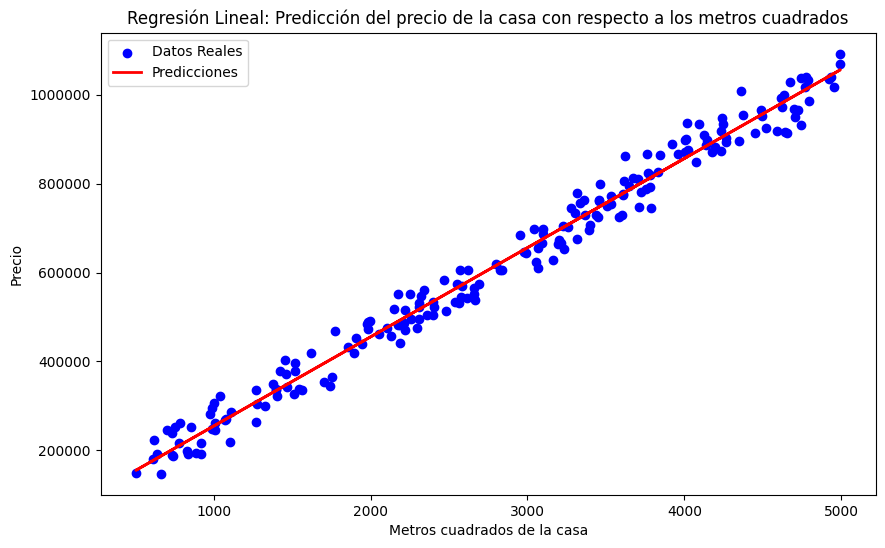

In [10]:
X = houses[['Square_Footage']]
y = houses['House_Price']


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")
print(f"Coeficientes de la regresión: {model.coef_}")
print(f"Intersección de la regresión: {model.intercept_}")

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Datos Reales')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicciones')
plt.xlabel('Metros cuadrados de la casa')
plt.ylabel('Precio')
plt.ticklabel_format(style = 'plain')
plt.title('Regresión Lineal: Predicción del precio de la casa con respecto a los metros cuadrados')
plt.legend()
plt.show()

### RMSE

**RMSE** = 32.885,948: Esto indica que en promedio, el modelo se equivoca por aproximadamente unos 33.000 mil en el precio. Como los precios van desde 111.625.9 a 1.108.237 y el promedio es de 618.861. Entonces:

**( RMSE / Promedio ) × 100 = ( 32.886 / 618.861 ) × 100 = 5,3%**

El RMSE representa approximadamente un 5.3% del precio promedio.
    
Esto sugiere que el modelo tiene un error relativamente bajo en términos porcentuales. Aún así, el error absoluto (32.886) es pequeño comparado con el máximo (1.1M) pero significativo frente al mínimo (111K).


### **Regresión multivariable:** 'Square_Footage', 'Lot_Size', 'Garage_Size', 'Year_Built' y 'Num_Bedrooms':

Mean Squared Error (MSE): 150737599.2311102
Root Mean Squared Error (RMSE): 12277.524149074608
R-squared (R^2): 0.9976614912822687
Coeficientes de la regresión: [  199.26336169 15134.74844583  5349.28966348   993.75935505
 10414.54930796]
Intersección de la regresión: -1994940.5307157096


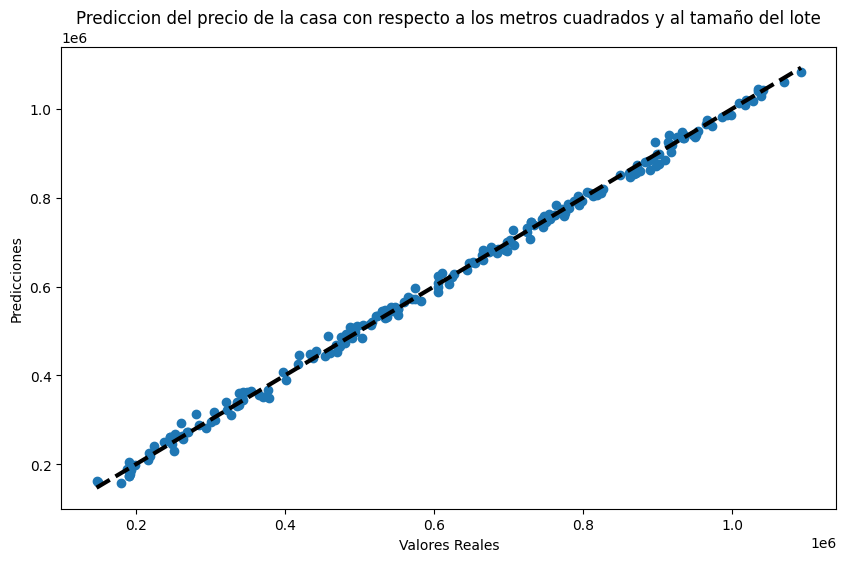

In [38]:
X = houses[['Square_Footage', 'Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms']]
y = houses['House_Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")
print(f"Coeficientes de la regresión: {model.coef_}")
print(f"Intersección de la regresión: {model.intercept_}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Prediccion del precio de la casa con respecto a los metros cuadrados y al tamaño del lote')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()

### **Regresión multivariable:** 'Lot_Size', 'Garage_Size', 'Year_Built' y 'Num_Bedrooms' (Sin la mejor variable, 'Square_Footage')

Mean Squared Error (MSE): 66554830476.41556
Root Mean Squared Error (RMSE): 257982.22899342419
R-squared (R^2): -0.032516452896441894
Coeficientes de la regresión: [38941.43291317 21596.13416119   778.99044969  3964.90958415]
Intersección de la regresión: -1070852.001413696


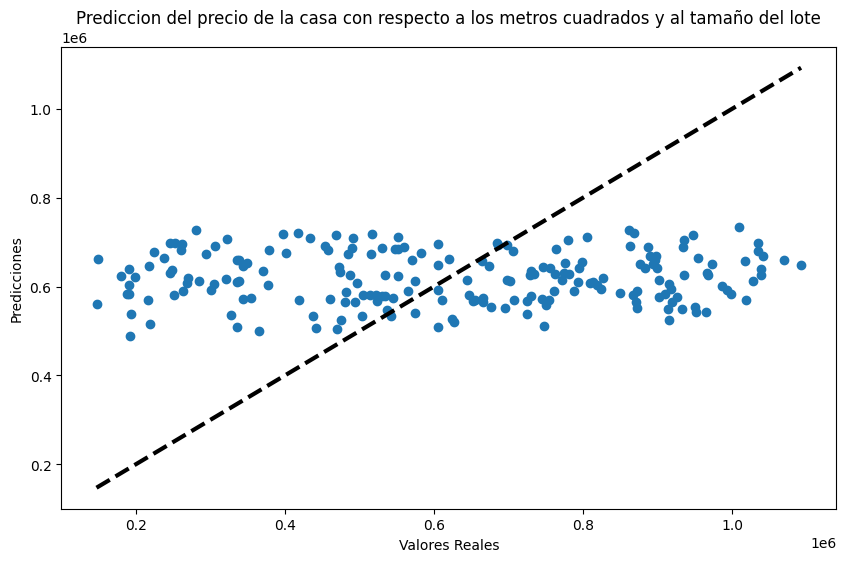

In [58]:
X = houses[['Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms']]
y = houses['House_Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")
print(f"Coeficientes de la regresión: {model.coef_}")
print(f"Intersección de la regresión: {model.intercept_}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Prediccion del precio de la casa con respecto a los metros cuadrados y al tamaño del lote')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()

# **Regresión Ridge**
### Utilizando solo la mejor variable: 'Square_Footage'


Coeficientes (variables escaladas):
Square_Footage: 251087.21509537066
Intercepto (escalado): 618576.0544203855


Coeficientes (escala original):
Square_Footage: 200.55103594188944
Intercepto (escala original): 54245.49438350287
Mejor alpha: 0.023299518105153717
Mean Squared Error (MSE): 1081452638.8241127
Root Mean Squared Error (RMSE): 32885.44721946339
R-squared (R^2): 0.9832225905374388


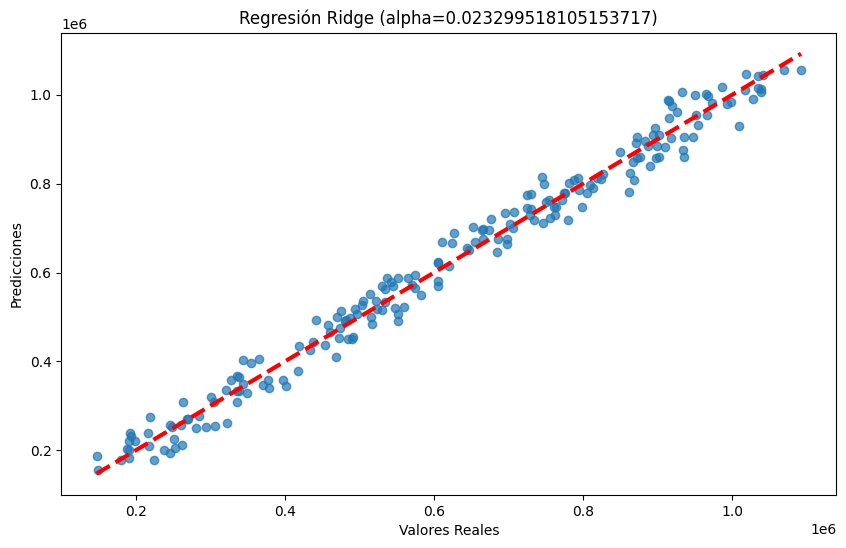

In [88]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

# Variables de entrada y salida
X = houses[['Square_Footage']]
y = houses['House_Price']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: Escalado + Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Rango de valores de alpha a probar
param_grid = {
    'ridge__alpha': np.logspace(-2, 7, 50)
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge__alpha']

#####

# ----------- Coeficientes ----------
ridge = best_model.named_steps['ridge']
scaler = best_model.named_steps['scaler']

coeficientes = ridge.coef_
intercepto = ridge.intercept_

print("\nCoeficientes (variables escaladas):")
for nombre, coef in zip(X.columns, coeficientes):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escalado): {intercepto}")
print("")


coef_original = coeficientes / scaler.scale_
intercepto_original = intercepto - np.sum(scaler.mean_ / scaler.scale_ * coeficientes)

print("\nCoeficientes (escala original):")
for nombre, coef in zip(X.columns, coef_original):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escala original): {intercepto_original}")

#####

# Predicciones
y_pred = best_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mejor alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Regresión Ridge (alpha={best_alpha})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.show()

### Utilizando las variables 'Square_Footage', 'Lot_Size', 'Garage_Size', 'Year_Built' y 'Num_Bedrooms'


Coeficientes (variables escaladas):
Square_Footage: 249467.70601375747
Lot_Size: 19408.17987757949
Garage_Size: 4386.292364371303
Year_Built: 20665.966962130125
Num_Bedrooms: 14792.986467385754
Intercepto (escalado): 618576.0544203854


Coeficientes (escala original):
Square_Footage: 199.257484520279
Lot_Size: 15134.982071513195
Garage_Size: 5349.634304683337
Year_Built: 993.7220745516423
Num_Bedrooms: 10414.0500285859
Intercepto (escala original): -1994849.4354842235
Mejor alpha: 0.023299518105153717
Mean Squared Error (MSE): 150763216.6221727
Root Mean Squared Error (RMSE): 12278.56736847474
R-squared (R^2): 0.9976610938599093


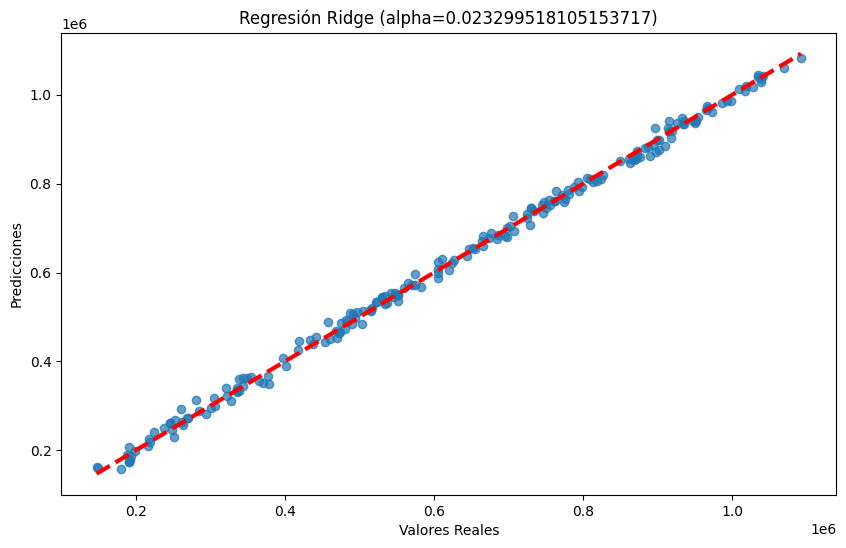

In [97]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

# Variables de entrada y salida
X = houses[['Square_Footage', 'Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms']]
y = houses['House_Price']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: Escalado + Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Rango de valores de alpha a probar
param_grid = {
    'ridge__alpha': np.logspace(-2, 7, 50)
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge__alpha']

#####

# ----------- Coeficientes ----------
ridge = best_model.named_steps['ridge']
scaler = best_model.named_steps['scaler']

coeficientes = ridge.coef_
intercepto = ridge.intercept_

print("\nCoeficientes (variables escaladas):")
for nombre, coef in zip(X.columns, coeficientes):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escalado): {intercepto}")
print("")


coef_original = coeficientes / scaler.scale_
intercepto_original = intercepto - np.sum(scaler.mean_ / scaler.scale_ * coeficientes)

print("\nCoeficientes (escala original):")
for nombre, coef in zip(X.columns, coef_original):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escala original): {intercepto_original}")

#####


# Predicciones
y_pred = best_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mejor alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Regresión Ridge (alpha={best_alpha})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.show()

### Resultados:

**Coeficientes (escala original):**

    - Square_Footage: 199.257484520279
    - Lot_Size: 15134.982071513195
    - Garage_Size: 5349.634304683337
    - Year_Built: 993.7220745516423
    - Num_Bedrooms: 10414.0500285859
    - Intercepto: -1994849.4354842235

Mejor alpha: 0.023299518105153717

Mean Squared Error (MSE): 150763216.6221727

Root Mean Squared Error (RMSE): 12278.56736847474

R-squared (R^2): 0.9976610938599093

### Utilizando las variables: 'Lot_Size', 'Garage_Size', 'Year_Built' y 'Num_Bedrooms' (sin la mejor, 'Square_Footage')


Coeficientes (variables escaladas):
Lot_Size: 43886.618792038804
Garage_Size: 15514.653766421448
Year_Built: 13885.526979517701
Num_Bedrooms: 5001.429898998903
Neighborhood_Quality: -2826.8148005391117
Intercepto (escalado): 618576.0544203855


Coeficientes (escala original):
Lot_Size: 34223.87842582592
Garage_Size: 18922.068371069236
Year_Built: 667.6849286372263
Num_Bedrooms: 3520.934822557469
Neighborhood_Quality: -970.2611342516943
Intercepto (escala original): -827158.0445988553
Mejor alpha: 109.85411419875595
Mean Squared Error (MSE): 65947894487.66083
Root Mean Squared Error (RMSE): 256803.22133427538
R-squared (R^2): -0.023100586463331574


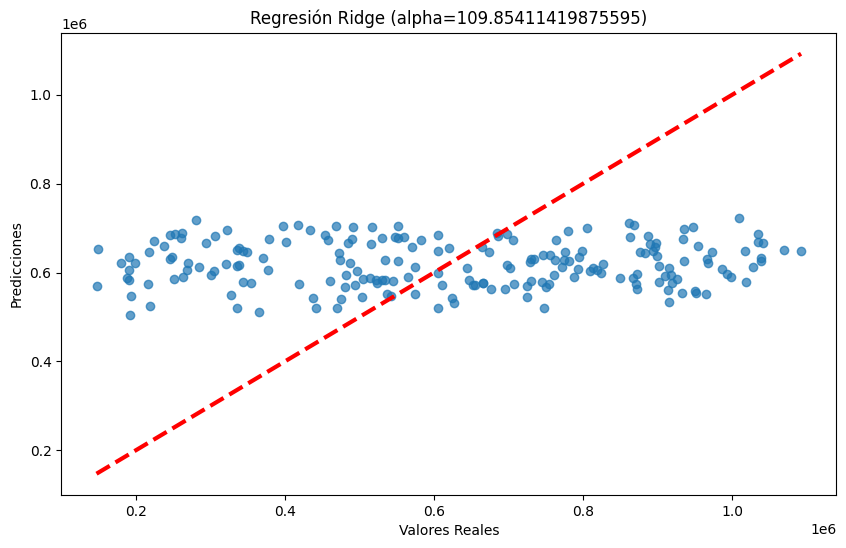

In [98]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

# Variables de entrada y salida
X = houses[['Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms', 'Neighborhood_Quality']]
y = houses['House_Price']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: Escalado + Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Rango de valores de alpha a probar
param_grid = {
    'ridge__alpha': np.logspace(-2, 7, 50)
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge__alpha']


#####

# ----------- Coeficientes ----------
ridge = best_model.named_steps['ridge']
scaler = best_model.named_steps['scaler']

coeficientes = ridge.coef_
intercepto = ridge.intercept_

print("\nCoeficientes (variables escaladas):")
for nombre, coef in zip(X.columns, coeficientes):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escalado): {intercepto}")
print("")


coef_original = coeficientes / scaler.scale_
intercepto_original = intercepto - np.sum(scaler.mean_ / scaler.scale_ * coeficientes)

print("\nCoeficientes (escala original):")
for nombre, coef in zip(X.columns, coef_original):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escala original): {intercepto_original}")

#####


# Predicciones
y_pred = best_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mejor alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Regresión Ridge (alpha={best_alpha})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.show()

### Resultados:

**Coeficientes (escala original):**

   - Lot_Size: 34223.87842582592
   - Garage_Size: 18922.068371069236
   - Year_Built: 667.6849286372263
   - Num_Bedrooms: 3520.934822557469
   - Neighborhood_Quality: -970.2611342516943
   - Intercepto (escala original): -827158.0445988553

Mejor alpha: 109.85411419875595

Mean Squared Error (MSE): 65947894487.66083

Root Mean Squared Error (RMSE): 256803.22133427538

R-squared (R^2): -0.023100586463331574

# **Regresión de Lasso**
### Utilizando sólo la variable 'Square_Footage'



Coeficientes (variables escaladas):
Square_Footage: 251085.8427455258
Intercepto (escalado): 618576.0544203855


Coeficientes (escala original):
Square_Footage: 200.54993980410737
Intercepto (escala original): 54248.57880560786
Mejor alpha: 8.685113737513529
Mean Squared Error (MSE): 1081446475.4026904
Root Mean Squared Error (RMSE): 32885.35350886
R-squared (R^2): 0.9832226861553524


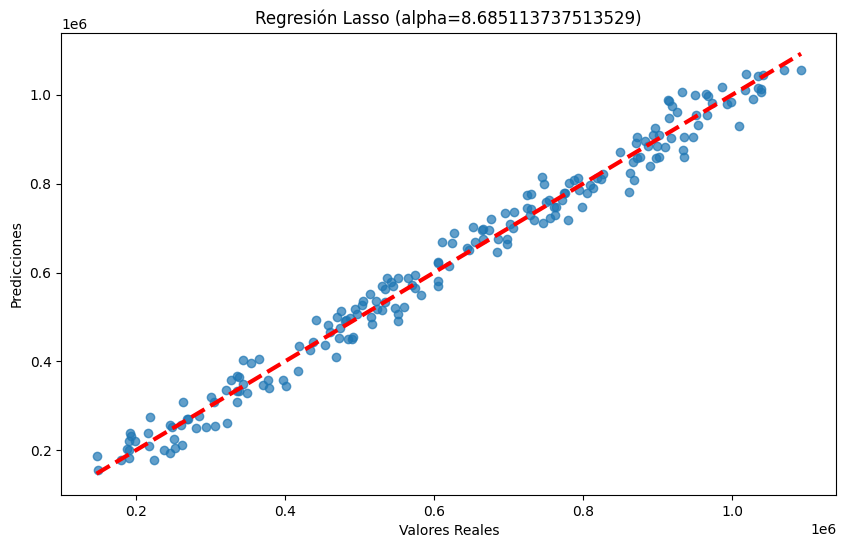

In [91]:
from sklearn.linear_model import Lasso 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Variables de entrada y salida
X = houses[['Square_Footage']]
y = houses['House_Price']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: Escalado + Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))  # Aumentar max_iter para convergencia
])

# Rango de valores de alpha 
param_grid = {
    'lasso__alpha': np.logspace(-2, 7, 50) 
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['lasso__alpha']

#####

# ----------- Coeficientes ----------
lasso = best_model.named_steps['lasso']
scaler = best_model.named_steps['scaler']

coeficientes = lasso.coef_
intercepto = lasso.intercept_

print("\nCoeficientes (variables escaladas):")
for nombre, coef in zip(X.columns, coeficientes):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escalado): {intercepto}")
print("")


coef_original = coeficientes / scaler.scale_
intercepto_original = intercepto - np.sum(scaler.mean_ / scaler.scale_ * coeficientes)

print("\nCoeficientes (escala original):")
for nombre, coef in zip(X.columns, coef_original):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escala original): {intercepto_original}")

#####

# Predicciones
y_pred = best_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mejor alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Regresión Lasso (alpha={best_alpha})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.show()

### Utilizando las variables 'Square_Footage', 'Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms'


Coeficientes (variables escaladas):
Square_Footage: 249457.04212493278
Lot_Size: 19388.439960562682
Garage_Size: 4367.7252642494805
Year_Built: 20643.839538191336
Num_Bedrooms: 14774.440568459775
Intercepto (escalado): 618576.0544203854


Coeficientes (escala original):
Square_Footage: 199.24896694621555
Lot_Size: 15119.588392557878
Garage_Size: 5326.989394700364
Year_Built: 992.6580783853254
Num_Bedrooms: 10400.993982082642
Intercepto (escala original): -1992606.9899309091
Mejor alpha: 20.235896477251575
Mean Squared Error (MSE): 150724873.34469327
Root Mean Squared Error (RMSE): 12277.005878661674
R-squared (R^2): 0.9976616887087666


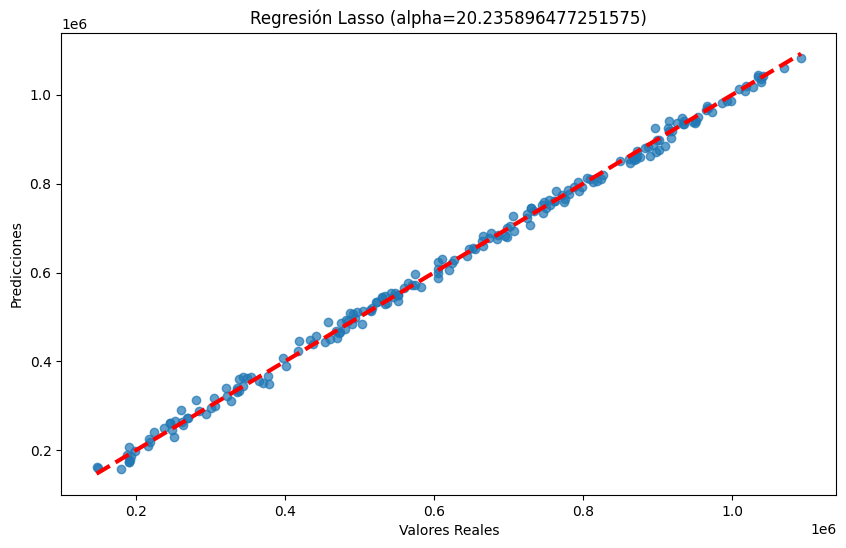

In [100]:
from sklearn.linear_model import Lasso 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Variables de entrada y salida
X = houses[['Square_Footage', 'Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms']]
y = houses['House_Price']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: Escalado + Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Rango de valores de alpha 
param_grid = {
    'lasso__alpha': np.logspace(-2, 7, 50) 
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['lasso__alpha']

#####

# ----------- Coeficientes ----------
lasso = best_model.named_steps['lasso']
scaler = best_model.named_steps['scaler']

coeficientes = lasso.coef_
intercepto = lasso.intercept_

print("\nCoeficientes (variables escaladas):")
for nombre, coef in zip(X.columns, coeficientes):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escalado): {intercepto}")
print("")


coef_original = coeficientes / scaler.scale_
intercepto_original = intercepto - np.sum(scaler.mean_ / scaler.scale_ * coeficientes)

print("\nCoeficientes (escala original):")
for nombre, coef in zip(X.columns, coef_original):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escala original): {intercepto_original}")

#####

# Predicciones
y_pred = best_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mejor alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Regresión Lasso (alpha={best_alpha})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.show()

### Utilizando sólo las variables 'Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms' (sin la mejor 'Square_Footage')


Coeficientes (variables escaladas):
Lot_Size: 46478.011161590795
Garage_Size: 14633.025406890803
Year_Built: 12586.793766107605
Num_Bedrooms: 2652.432808953728
Neighborhood_Quality: -144.17947025396452
Intercepto (escalado): 618576.0544203855


Coeficientes (escala original):
Lot_Size: 36244.71073987169
Garage_Size: 17846.811884648763
Year_Built: 605.2354015725621
Num_Bedrooms: 1867.2746054900072
Neighborhood_Quality: -49.48740763552703
Intercepto (escala original): -707831.5581451866
Mejor alpha: 3237.4575428176468
Mean Squared Error (MSE): 66073072212.60076
Root Mean Squared Error (RMSE): 257046.82883202579
R-squared (R^2): -0.025042565123805094


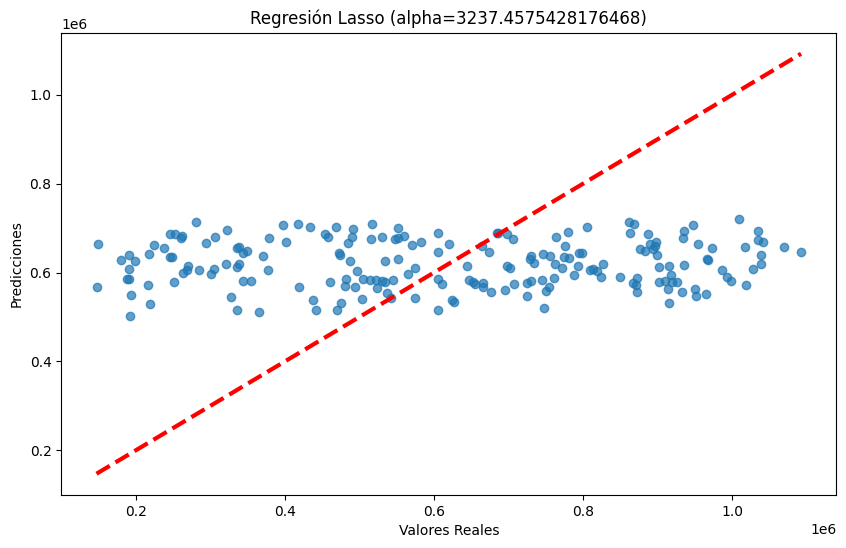

In [101]:
from sklearn.linear_model import Lasso 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Variables de entrada y salida
X = houses[['Lot_Size', 'Garage_Size', 'Year_Built', 'Num_Bedrooms', 'Neighborhood_Quality']]
y = houses['House_Price']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: Escalado + Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Rango de valores de alpha 
param_grid = {
    'lasso__alpha': np.logspace(-2, 7, 50) 
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['lasso__alpha']

#####

# ----------- Coeficientes ----------
lasso = best_model.named_steps['lasso']
scaler = best_model.named_steps['scaler']

coeficientes = lasso.coef_
intercepto = lasso.intercept_

print("\nCoeficientes (variables escaladas):")
for nombre, coef in zip(X.columns, coeficientes):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escalado): {intercepto}")
print("")


coef_original = coeficientes / scaler.scale_
intercepto_original = intercepto - np.sum(scaler.mean_ / scaler.scale_ * coeficientes)

print("\nCoeficientes (escala original):")
for nombre, coef in zip(X.columns, coef_original):
    print(f"{nombre}: {coef}")

print(f"Intercepto (escala original): {intercepto_original}")

#####

# Predicciones
y_pred = best_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mejor alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Regresión Lasso (alpha={best_alpha})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.show()

# Análisis de resultados

### Comparación de todos los modelos 

| Modelo                        | Variables            | Coeficientes (escala original)              | α óptimo | R^2     | RMSE    |
| ----------------------------- | -------------------- | ------------------------------------------- | -------- | ------- | ------- |
| **Lineal simple**             | `Square_Footage`     | 200.56                                      | —        | 0.9832  | 32,886  |
| **Ridge simple**              | `Square_Footage`     | 200.55                                      | 0.0233   | 0.9832  | 32,885  |
| **Lasso simple**              | `Square_Footage`     | 200.55                                      | 8.6851   | 0.9832  | 32,885  |
| **Lineal multivariable**      | Todas                | 199.26, 15134.75, 5349.29, 993.76, 10414.55 | —        | 0.9977  | 12,278  |
| **Ridge multivariable**       | Todas                | 199.26, 15134.98, 5349.63, 993.72, 10414.05 | 0.0233   | 0.9977  | 12,279  |
| **Lasso multivariable**       | Todas                | 199.25, 15119.59, 5326.99, 992.66, 10400.99 | 20.2359  | 0.9977  | 12,277  |
| **Lineal sin mejor variable** | Sin `Square_Footage` | 38941.43, 21596.13, 778.99, 3964.91         | —        | -0.0325 | 257,982 |
| **Ridge sin mejor variable**  | Sin `Square_Footage` | 34152.33, 18884.44, 668.06, 3576.08         | 109.8541 | -0.0231 | 256,804 |
| **Lasso sin mejor variable**  | Sin `Square_Footage` | 38801.54, 21401.82, 769.99, 3856.43         | 167.6833 | -0.0321 | 257,930 |



- Al usar más variables relevantes **R^2 sube, MSE baja.**

- Cuando se **quitó** la variable más importante (Square_Footage), destruyó el modelo (R^2 negativo).

- **Ridge y Lasso** tienen resultados casi idénticos, esto se puede justificar porque las variables no son altamente redundantes y **todas aportan algo**. No hay grandes coeficientes “eliminados” por Lasso.

- Todos los métodos dan prácticamente el mismo resultado cuando usan las mismas variables, porque no hay **multicolinealidad grave** y los **datos parecen limpios.**


Interpretación respecto a **Lasso sin mejor variable:**

- **Lot_Size (38.801,54):** Manteniendo el resto de las variables constantes, por cada incremento de 1 unidad en el tamaño del terreno, el precio estimado de la casa aumenta 38 801.54 unidades monetarias.

- **Garage_Size (21.401,82):** Con las demás variables fijas, cada unidad extra de tamaño de garaje (por ejemplo, autos) se asocia con un aumento de 21 401.82 en el precio.

- **Num_Bedrooms (3.856,43):** Cada dormitorio adicional aumenta el precio estimado en 3 856.43, manteniendo las demás variables constantes.

- **Intercepto (-1.052.065,69):** Representa el precio estimado de una casa si todas las variables tuvieran valor 0. No tiene una interpretación práctica directa en este caso

Otras interretaciones: 

- **α óptimo:** Es el nivel de regularización que mejor **balancea** el ajuste del modelo y la prevención de **sobreajuste.**

- **R^2:** En el caso de **Lasso multivariable R^2 = 0.998**, significa que el 99% de la variabilidad en el precio de la casa se **explica** por las variables incluidas en el modelo.

- **RMSE:** En el caso de Ridge simple, RMSE es 32.885, eso quiere decir que en **promedio** las **predicciones del modelo se equivocan** approximadamente 33.000 unidades monetarias.

En conclusión, los modelos que incluyen todas las variables son los más recomendables, 
ya que aprovechan la variable más influyente ('Square_Footage'), tienen el menor RMSE (cuánto se equivoca el modelo), y el mayor R^2 (qué proporción de la variabilidad en el precio de la casa se explica por las variables incluidas en el modelo) y, en el caso de Ridge y Lasso, mantienen el sobreajuste bajo control.